In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **helper functions**

In [2]:
# build MultiScaleDeformableAttention
!cd /content/drive/MyDrive/models/dino/ops
!export TORCH_CUDA_ARCH_LIST="7.5;8.0;8.6;8.9"   # 7.5 for grand-challenge's online GPU (T4), 8.6 for 3090
!python /content/drive/MyDrive/models/dino/ops/setup.py build install

running build
running build_ext
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:529: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:448: UserWarning: The detected CUDA version (12.5) has a minor version mismatch with the version that was used to compile PyTorch (12.4). Most likely this shouldn't be a problem.
  warnings.warn(CUDA_MISMATCH_WARN.format(cuda_str_version, torch.version.cuda))
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:458: UserWarning: There are no x86_64-linux-gnu-g++ version bounds defined for CUDA version 12.5
  warnings.warn(f'There are no {compiler_name} version bounds defined for CUDA version {cuda_str_version}')
building 'MultiScaleDeformableAttention' extension
creating build/temp.linux-x86_64-cpyth

# **important note don't forget to restart the session after building MultiScaleDeformableAttention**

In [ ]:
# build MultiScaleDeformableAttention
!cd /content/drive/MyDrive/models/dino/ops
!export TORCH_CUDA_ARCH_LIST="7.5;8.0;8.6;8.9"   # 7.5 for grand-challenge's online GPU (T4), 8.6 for 3090
!python /content/drive/MyDrive/models/dino/ops/setup.py build install

running build
running build_ext
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:529: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:448: UserWarning: The detected CUDA version (12.5) has a minor version mismatch with the version that was used to compile PyTorch (12.4). Most likely this shouldn't be a problem.
  warnings.warn(CUDA_MISMATCH_WARN.format(cuda_str_version, torch.version.cuda))
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:458: UserWarning: There are no x86_64-linux-gnu-g++ version bounds defined for CUDA version 12.5
  warnings.warn(f'There are no {compiler_name} version bounds defined for CUDA version {cuda_str_version}')
building 'MultiScaleDeformableAttention' extension
creating build/temp.linux-x86_64-cpyth

In [ ]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import torch
import numpy as np
from models.unet.utils import load_state
from train_unet import SegmentationDataset, TransformedDataset, Preload
from models.unet.UNet import UNet
from models.unet.SE_UNet import SEUNet
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
from scipy.ndimage import center_of_mass
import os

##### Plot Training Curves
def plot_unet_training(log_dir, model_name="U-Net"):
    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()

    train_total = ea.Scalars("train_loss/total")
    val_total = ea.Scalars("validation_loss/total")
    train_dice = ea.Scalars("train_loss/dice")
    val_dice = ea.Scalars("validation_loss/dice")
    train_ce = ea.Scalars("train_loss/ce")
    val_ce = ea.Scalars("validation_loss/ce")

    steps = [e.step for e in train_total]

    plt.figure(figsize=(14, 6))

    # Plot total loss
    plt.subplot(1, 2, 1)
    plt.plot(steps, [e.value for e in train_total], label="Train Total")
    plt.plot(steps, [e.value for e in val_total], label="Validation Total")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Total Loss")
    plt.legend()
    plt.grid(True)

    # Plot Dice and CE losses
    plt.subplot(1, 2, 2)
    plt.plot(steps, [e.value for e in train_dice], label="Train Dice")
    plt.plot(steps, [e.value for e in val_dice], label="Validation Dice")
    plt.plot(steps, [e.value for e in train_ce], label="Train CE")
    plt.plot(steps, [e.value for e in val_ce], label="Validation CE")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Dice vs CE Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
#------------------------------------------------------------------#
###### Evaluation Code
def evaluate_segmentation_model(model, dataloader, device='cuda', num_classes=33):
    model.eval()
    dice_scores = []
    iou_scores = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            preds = model(images)
            preds = torch.argmax(preds, dim=1)

            for pred, gt in zip(preds, masks):
                for cls in range(1, num_classes):  # skip background class 0
                    pred_inds = (pred == cls)
                    gt_inds = (gt == cls)

                    if gt_inds.sum() == 0 and pred_inds.sum() == 0:
                        continue  # skip class if absent

                    intersection = (pred_inds & gt_inds).sum().item()
                    union = (pred_inds | gt_inds).sum().item()
                    dice = (2. * intersection) / (pred_inds.sum().item() + gt_inds.sum().item() + 1e-8)
                    iou = intersection / (union + 1e-8)

                    dice_scores.append(dice)
                    iou_scores.append(iou)

    mean_dice = np.mean(dice_scores)
    mean_iou = np.mean(iou_scores)
    return mean_iou, mean_dice

#-------------------------------------------------------------------------------------------------
def evaluate_all_checkpoints(model_class, checkpoint_dir, val_loader, model_name, out_channels=33):
    results = []

    for ckpt_file in sorted(os.listdir(checkpoint_dir)):
        if not ckpt_file.endswith(".pth"):
            continue  # skip non-checkpoint files

        ckpt_path = os.path.join(checkpoint_dir, ckpt_file)

        # Initialize model
        if model_name.lower() == "unet":
            model = model_class(in_channels=1, out_channels=out_channels).cuda()
        else:
            model = model_class(n_cls=out_channels).cuda()

        # Load checkpoint
        try:
            ckpt = torch.load(ckpt_path)
            model.load_state_dict(ckpt["model_state_dict"])
        except Exception as e:
            print(f"Failed to load {ckpt_file}: {e}")
            continue

        # Evaluate
        iou, dice = evaluate_segmentation_model(model, val_loader)

        # Save result
        results.append((ckpt_file, iou, dice))
        print(f"[{model_name}] {ckpt_file} => IoU: {iou:.4f}, Dice: {dice:.4f}")

    return results


#--------------------------------------------------------------------------------------------------
def visualize_model_predictions(model, dataset, model_name="Model", device='cuda', num_samples=3, num_classes=32):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    with torch.no_grad():
        for idx in indices:
            image, mask = dataset[idx]
            input_tensor = image.unsqueeze(0).to(device)

            output = model(input_tensor)
            pred_mask = torch.argmax(output.squeeze(), dim=0).cpu()

            cmap = plt.get_cmap('nipy_spectral', num_classes + 1)
            fig, axes = plt.subplots(1, 3, figsize=(22, 9))  # Bigger figure

            # Input image
            axes[0].imshow(image.squeeze().cpu(), cmap='gray')
            axes[0].set_title(f'{model_name} - Input Image', fontsize=24)
            axes[0].axis('off')

            # Ground Truth
            axes[1].imshow(mask.cpu(), cmap=cmap, vmin=0, vmax=num_classes)
            axes[1].set_title('Ground Truth Mask (Labeled)', fontsize=24)
            axes[1].axis('off')
            for label in torch.unique(mask):
                if label == 0:
                    continue
                coords = (mask == label).numpy().astype(np.uint8)
                cy, cx = center_of_mass(coords)
                axes[1].text(cx, cy, str(label.item()), color='white', fontsize=14, fontweight='bold', ha='center', va='center')

            # Prediction
            axes[2].imshow(pred_mask, cmap=cmap, vmin=0, vmax=num_classes)
            axes[2].set_title(f'{model_name} - Predicted Mask (Labeled)', fontsize=24)
            axes[2].axis('off')
            for label in torch.unique(pred_mask):
                if label == 0:
                    continue
                coords = (pred_mask == label).numpy().astype(np.uint8)
                cy, cx = center_of_mass(coords)
                axes[2].text(cx, cy, str(label.item()), color='white', fontsize=14, fontweight='bold', ha='center', va='center')

            plt.suptitle(f"{model_name}", fontsize=24)
            plt.tight_layout()
            plt.show()


In [ ]:
!pip install tensorboard
unet_log_dir = "/content/drive/MyDrive/output_unet_enum32_07-25_13-34"
seunet_log_dir = "/content/drive/MyDrive/output_seunet_enum32_07-25_16-46"

DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/MultiScaleDeformableAttention-1.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [ ]:
##############################################
# train unet segmentation
!python /content/drive/MyDrive/train_unet.py \
    --output_dir /content/drive/MyDrive/output_unet_enum32_$(date +%m-%d_%H-%M) \
    --dataset_dir /content/drive/MyDrive/dentex_dataset/segmentation/enumeration32 \
    --num_classes 32 --model unet

Streaming output truncated to the last 5000 lines.
Validation batch: 2/4
Validation batch: 3/4
Validation loss: 0.3770567998290062, 0.3227507472038269
Epoch: 83
Train batch: 0/16
Train batch: 1/16
Train batch: 2/16
Train batch: 3/16
Train batch: 4/16
Train batch: 5/16
Train batch: 6/16
Train batch: 7/16
Train batch: 8/16
Train batch: 9/16
Train batch: 10/16
Train batch: 11/16
Train batch: 12/16
Train batch: 13/16
Train batch: 14/16
Train batch: 15/16
Train loss: 0.2720895064994693, 0.22505819145590067
Validation batch: 0/4
Validation batch: 1/4
Validation batch: 2/4
Validation batch: 3/4
Validation loss: 0.40813761949539185, 0.3474256843328476
Epoch: 84
Train batch: 0/16
Train batch: 1/16
Train batch: 2/16
Train batch: 3/16
Train batch: 4/16
Train batch: 5/16
Train batch: 6/16
Train batch: 7/16
Train batch: 8/16
Train batch: 9/16
Train batch: 10/16
Train batch: 11/16
Train batch: 12/16
Train batch: 13/16
Train batch: 14/16
Train batch: 15/16
Train loss: 0.24268391635268927, 0.195792259

In [ ]:
!python /content/drive/MyDrive/train_unet.py \
    --output_dir /content/drive/MyDrive/output_seunet_enum32_$(date +%m-%d_%H-%M) \
    --dataset_dir /content/drive/MyDrive/dentex_dataset/segmentation/enumeration32 \
    --num_classes 32 --model seunet

Streaming output truncated to the last 5000 lines.
Validation batch: 1/4
Validation batch: 2/4
Validation batch: 3/4
Validation loss: 0.3916693478822708, 0.32457882910966873
Epoch: 83
Train batch: 0/16
Train batch: 1/16
Train batch: 2/16
Train batch: 3/16
Train batch: 4/16
Train batch: 5/16
Train batch: 6/16
Train batch: 7/16
Train batch: 8/16
Train batch: 9/16
Train batch: 10/16
Train batch: 11/16
Train batch: 12/16
Train batch: 13/16
Train batch: 14/16
Train batch: 15/16
Train loss: 0.27095621451735497, 0.21887385286390781
Validation batch: 0/4
Validation batch: 1/4
Validation batch: 2/4
Validation batch: 3/4
Validation loss: 0.3810497000813484, 0.3071286603808403
Epoch: 84
Train batch: 0/16
Train batch: 1/16
Train batch: 2/16
Train batch: 3/16
Train batch: 4/16
Train batch: 5/16
Train batch: 6/16
Train batch: 7/16
Train batch: 8/16
Train batch: 9/16
Train batch: 10/16
Train batch: 11/16
Train batch: 12/16
Train batch: 13/16
Train batch: 14/16
Train batch: 15/16
Train loss: 0.2427997

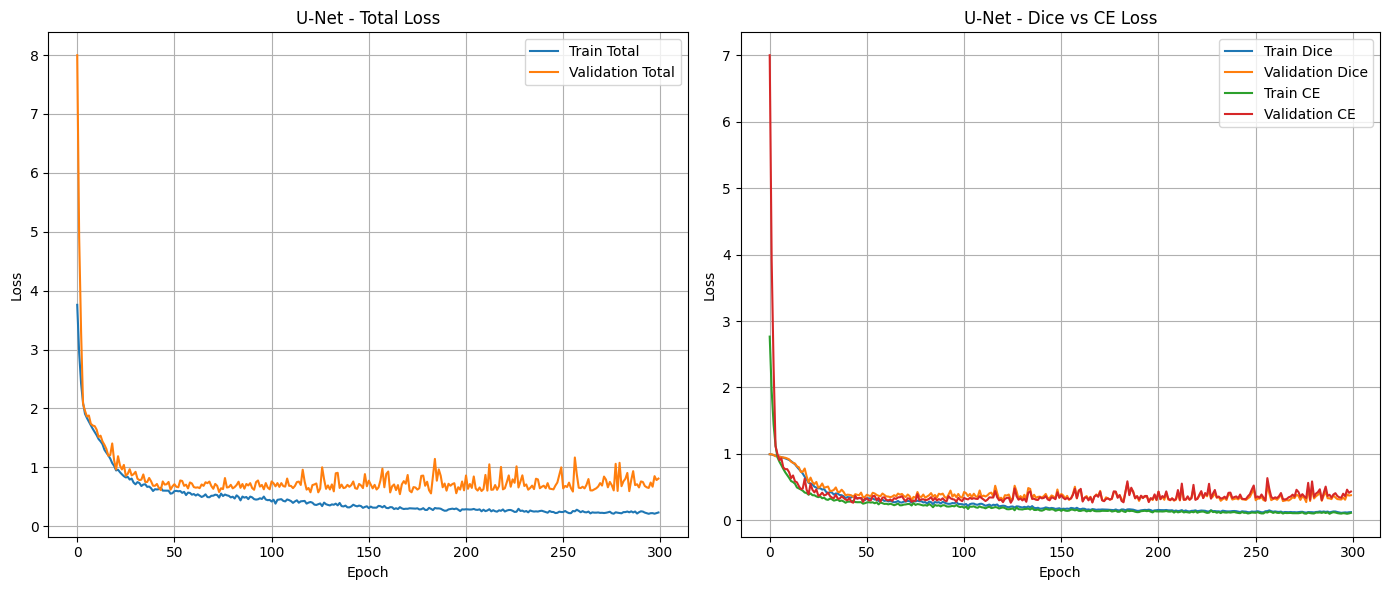

In [ ]:
plot_unet_training(unet_log_dir)

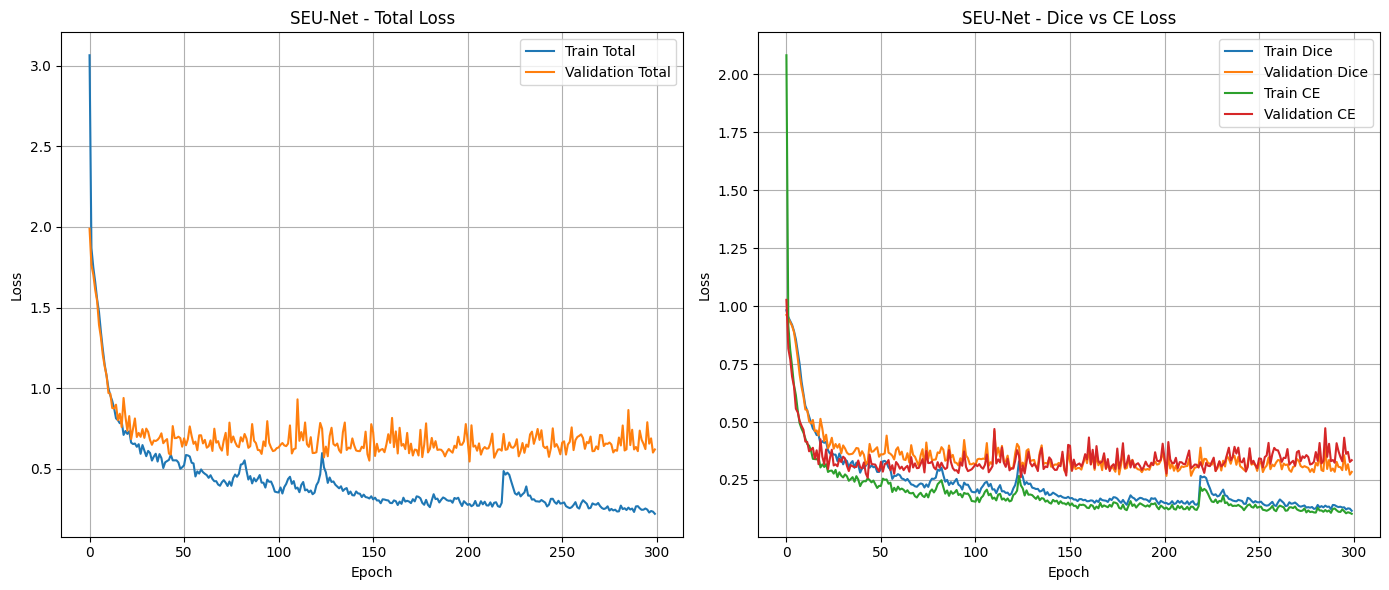

In [ ]:
plot_unet_training(seunet_log_dir, model_name='SEU-Net')

# **Load Model and Validation Dataset**

In [ ]:
# Set this to your actual path
dataset_dir = "/content/drive/MyDrive/dentex_dataset/segmentation/enumeration32"  # Should contain image_names.json, xrays/, masks/
unet_ckpt = "/content/drive/MyDrive/output_unet_enum32_07-25_13-34/epoch_166_loss_0.5442415252327919.pth"
seunet_ckpt = "/content/drive/MyDrive/output_seunet_enum32_07-25_16-46/epoch_148_loss_0.5509927049279213.pth"

In [ ]:
# Load and split dataset
dataset = Preload(SegmentationDataset(dataset_dir))
transformed_dataset = TransformedDataset(dataset, flip=0.1, crop=0.1, rotate=[-10, 10])

# Use the same seed and split ratio as in training
val_size = int(len(transformed_dataset) * 0.2)
train_size = len(transformed_dataset) - val_size
_, val_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, val_size],
                                               generator=torch.Generator().manual_seed(42))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


In [ ]:
# -------------------- U-Net --------------------
unet_model = UNet(in_channels=1, out_channels=33).cuda()

# Load U-Net checkpoint (update path if needed)
unet_ckpt = torch.load(unet_ckpt)  # replace with actual path
unet_model.load_state_dict(unet_ckpt["model_state_dict"])

# Evaluate U-Net
iou_u, dice_u = evaluate_segmentation_model(unet_model, val_loader)

# -------------------- SE-U-Net --------------------
seunet_model = SEUNet(n_cls=33).cuda()

# Load SE-U-Net checkpoint (update path if needed)
seunet_ckpt = torch.load(seunet_ckpt)  # replace with actual path
seunet_model.load_state_dict(seunet_ckpt["model_state_dict"])

# Evaluate SE-U-Net
iou_se, dice_se = evaluate_segmentation_model(seunet_model, val_loader)

# -------------------- Results --------------------
print("Evaluation Results:")
print(f"U-Net    => IoU: {iou_u:.4f}, Dice: {dice_u:.4f}")
print(f"SE-U-Net => IoU: {iou_se:.4f}, Dice: {dice_se:.4f}")


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.34it/s]

Evaluation Results:
U-Net    => IoU: 0.5695, Dice: 0.6698
SE-U-Net => IoU: 0.6056, Dice: 0.7096


In [ ]:
# U-Net
unet_results = evaluate_all_checkpoints(
    model_class=UNet,
    checkpoint_dir="/content/drive/MyDrive/output_unet_enum32_07-25_13-34",
    val_loader=val_loader,
    model_name="UNet",
    out_channels=33
)

Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.67it/s]


[UNet] epoch_0_loss_7.996900171041489.pth => IoU: 0.0016, Dice: 0.0031


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.86it/s]


[UNet] epoch_10_loss_1.639210045337677.pth => IoU: 0.0420, Dice: 0.0695


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.86it/s]


[UNet] epoch_11_loss_1.5140229314565659.pth => IoU: 0.1094, Dice: 0.1636


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.59it/s]


[UNet] epoch_120_loss_0.5760183408856392.pth => IoU: 0.5828, Dice: 0.6875


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.73it/s]


[UNet] epoch_124_loss_0.5749839693307877.pth => IoU: 0.5626, Dice: 0.6704


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.98it/s]


[UNet] epoch_13_loss_1.4399762600660324.pth => IoU: 0.1390, Dice: 0.2037


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.71it/s]


[UNet] epoch_14_loss_1.3817859888076782.pth => IoU: 0.1776, Dice: 0.2499


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.72it/s]


[UNet] epoch_15_loss_1.311018094420433.pth => IoU: 0.1774, Dice: 0.2503


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 12.14it/s]


[UNet] epoch_161_loss_0.5737679451704025.pth => IoU: 0.5910, Dice: 0.6946


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.60it/s]


[UNet] epoch_166_loss_0.5442415252327919.pth => IoU: 0.6176, Dice: 0.7173


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.70it/s]


[UNet] epoch_16_loss_1.1966603621840477.pth => IoU: 0.2755, Dice: 0.3733


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.86it/s]


[UNet] epoch_19_loss_1.1166050285100937.pth => IoU: 0.2835, Dice: 0.3797


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.68it/s]


[UNet] epoch_1_loss_4.910247296094894.pth => IoU: 0.0025, Dice: 0.0048


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.83it/s]


[UNet] epoch_20_loss_0.9616800099611282.pth => IoU: 0.3845, Dice: 0.4950


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.77it/s]


[UNet] epoch_25_loss_0.856471948325634.pth => IoU: 0.4495, Dice: 0.5579


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.89it/s]


[UNet] epoch_2_loss_3.2889350801706314.pth => IoU: 0.0052, Dice: 0.0102


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.40it/s]


[UNet] epoch_31_loss_0.8065525516867638.pth => IoU: 0.4565, Dice: 0.5534


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.78it/s]


[UNet] epoch_32_loss_0.7823406234383583.pth => IoU: 0.4917, Dice: 0.5976


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.53it/s]


[UNet] epoch_35_loss_0.7518964037299156.pth => IoU: 0.4887, Dice: 0.5901


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.91it/s]


[UNet] epoch_36_loss_0.7508791461586952.pth => IoU: 0.5350, Dice: 0.6437


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.90it/s]


[UNet] epoch_39_loss_0.687409445643425.pth => IoU: 0.5076, Dice: 0.6103


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.57it/s]


[UNet] epoch_3_loss_2.078949049115181.pth => IoU: 0.0002, Dice: 0.0004


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.79it/s]


[UNet] epoch_40_loss_0.685998797416687.pth => IoU: 0.5529, Dice: 0.6600


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.57it/s]


[UNet] epoch_42_loss_0.6502197273075581.pth => IoU: 0.5235, Dice: 0.6275


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.75it/s]


[UNet] epoch_43_loss_0.6136268600821495.pth => IoU: 0.5564, Dice: 0.6589


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.96it/s]


[UNet] epoch_4_loss_1.9598893970251083.pth => IoU: 0.0149, Dice: 0.0275


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.81it/s]


[UNet] epoch_5_loss_1.8634798526763916.pth => IoU: 0.0136, Dice: 0.0253


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.70it/s]


[UNet] epoch_73_loss_0.5804574638605118.pth => IoU: 0.5775, Dice: 0.6785


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.50it/s]


[UNet] epoch_7_loss_1.7402075976133347.pth => IoU: 0.0294, Dice: 0.0517


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 12.04it/s]


[UNet] epoch_8_loss_1.7095180451869965.pth => IoU: 0.0247, Dice: 0.0422


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.59it/s]


[UNet] epoch_9_loss_1.6993340104818344.pth => IoU: 0.0245, Dice: 0.0417


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.84it/s]

[UNet] last_epoch.pth => IoU: 0.5301, Dice: 0.6270


In [ ]:
# SE-U-Net
seunet_results = evaluate_all_checkpoints(
    model_class=SEUNet,
    checkpoint_dir="/content/drive/MyDrive/output_seunet_enum32_07-25_16-46",
    val_loader=val_loader,
    model_name="SEUNet",
    out_channels=33
)

Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.53it/s]


[SEUNet] epoch_0_loss_1.9891356378793716.pth => IoU: 0.0052, Dice: 0.0093


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.21it/s]


[SEUNet] epoch_10_loss_0.9704062640666962.pth => IoU: 0.4074, Dice: 0.5170


Evaluating: 100%|██████████| 32/32 [00:03<00:00,  9.96it/s]


[SEUNet] epoch_11_loss_0.9656246900558472.pth => IoU: 0.3833, Dice: 0.4873


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.60it/s]


[SEUNet] epoch_124_loss_0.5710706934332848.pth => IoU: 0.5906, Dice: 0.6944


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.22it/s]


[SEUNet] epoch_12_loss_0.8773802891373634.pth => IoU: 0.4113, Dice: 0.5131


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.28it/s]


[SEUNet] epoch_13_loss_0.8745789378881454.pth => IoU: 0.4425, Dice: 0.5477


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.37it/s]


[SEUNet] epoch_148_loss_0.5509927049279213.pth => IoU: 0.6150, Dice: 0.7141


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.25it/s]


[SEUNet] epoch_15_loss_0.8025735467672348.pth => IoU: 0.4333, Dice: 0.5267


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.14it/s]


[SEUNet] epoch_17_loss_0.759796530008316.pth => IoU: 0.4968, Dice: 0.6054


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.37it/s]


[SEUNet] epoch_1_loss_1.764553353190422.pth => IoU: 0.0121, Dice: 0.0217


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.16it/s]


[SEUNet] epoch_201_loss_0.5455089658498764.pth => IoU: 0.6130, Dice: 0.7109


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.23it/s]


[SEUNet] epoch_20_loss_0.7363436818122864.pth => IoU: 0.4719, Dice: 0.5767


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.41it/s]


[SEUNet] epoch_22_loss_0.6847904287278652.pth => IoU: 0.5315, Dice: 0.6367


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.52it/s]


[SEUNet] epoch_2_loss_1.7029197216033936.pth => IoU: 0.0422, Dice: 0.0713


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.33it/s]


[SEUNet] epoch_32_loss_0.679041925817728.pth => IoU: 0.5773, Dice: 0.6826


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.46it/s]


[SEUNet] epoch_33_loss_0.6492677293717861.pth => IoU: 0.5569, Dice: 0.6587


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.08it/s]


[SEUNet] epoch_3_loss_1.6102294623851776.pth => IoU: 0.0801, Dice: 0.1258


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.22it/s]


[SEUNet] epoch_42_loss_0.5946336314082146.pth => IoU: 0.5642, Dice: 0.6644


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.38it/s]


[SEUNet] epoch_43_loss_0.5892378464341164.pth => IoU: 0.5730, Dice: 0.6766


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.18it/s]


[SEUNet] epoch_4_loss_1.5414287000894547.pth => IoU: 0.1325, Dice: 0.1950


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.25it/s]


[SEUNet] epoch_5_loss_1.39324851334095.pth => IoU: 0.1485, Dice: 0.2131


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.15it/s]


[SEUNet] epoch_6_loss_1.3160459026694298.pth => IoU: 0.2298, Dice: 0.3169


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.51it/s]


[SEUNet] epoch_73_loss_0.5863173082470894.pth => IoU: 0.5801, Dice: 0.6803


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.25it/s]


[SEUNet] epoch_7_loss_1.2082609236240387.pth => IoU: 0.3241, Dice: 0.4350


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.21it/s]


[SEUNet] epoch_8_loss_1.1356839835643768.pth => IoU: 0.3333, Dice: 0.4394


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.42it/s]


[SEUNet] epoch_9_loss_1.0786947011947632.pth => IoU: 0.3828, Dice: 0.4965


Evaluating: 100%|██████████| 32/32 [00:03<00:00, 10.53it/s]

[SEUNet] last_epoch.pth => IoU: 0.6184, Dice: 0.7171


In [ ]:
# Sort by Dice descending
best_unet = sorted(unet_results, key=lambda x: x[2], reverse=True)
best_seunet = sorted(seunet_results, key=lambda x: x[2], reverse=True)

print("\nTop U-Net Checkpoints:")
for ckpt, iou, dice in best_unet[:3]:
    print(f"{ckpt}: IoU={iou:.4f}, Dice={dice:.4f}")

print("\nTop SE-U-Net Checkpoints:")
for ckpt, iou, dice in best_seunet[:3]:
    print(f"{ckpt}: IoU={iou:.4f}, Dice={dice:.4f}")


Top U-Net Checkpoints:
epoch_166_loss_0.5442415252327919.pth: IoU=0.6176, Dice=0.7173
epoch_161_loss_0.5737679451704025.pth: IoU=0.5910, Dice=0.6946
epoch_120_loss_0.5760183408856392.pth: IoU=0.5828, Dice=0.6875

Top SE-U-Net Checkpoints:
last_epoch.pth: IoU=0.6184, Dice=0.7171
epoch_148_loss_0.5509927049279213.pth: IoU=0.6150, Dice=0.7141
epoch_201_loss_0.5455089658498764.pth: IoU=0.6130, Dice=0.7109


Great question — let's unpack what these **evaluation losses/metrics** are and what they mean in the context of your **tooth enumeration segmentation task**.

---

## 🎯 You're Evaluating With:

### 1. **Dice Coefficient** (a.k.a. Sørensen–Dice index)

Measures the **overlap between predicted and ground truth masks**.

#### 📏 Formula:

$$
\text{Dice} = \frac{2 \cdot |\text{Prediction} \cap \text{GroundTruth}|}{|\text{Prediction}| + |\text{GroundTruth}|}
$$

#### ✅ Intuition:

* Dice = 1 → perfect overlap.
* Dice = 0 → no overlap.
* Sensitive to false negatives.
* **Commonly used in medical image segmentation**, where accuracy of object boundaries is critical.

#### 🦷 Example:

If a model detects most of a tooth but misses a small part, Dice drops noticeably — useful in assessing how well the **shape and region** are captured.

---

### 2. **IoU (Intersection over Union)** (a.k.a. Jaccard Index)

Also measures overlap, but in a slightly stricter way.

#### 📏 Formula:

$$
\text{IoU} = \frac{|\text{Prediction} \cap \text{GroundTruth}|}{|\text{Prediction} \cup \text{GroundTruth}|}
$$

#### ✅ Intuition:

* IoU = 1 → perfect match
* IoU = 0 → no overlap
* **Stricter than Dice**, especially for partial overlaps

#### 🦷 Example:

Useful when you want to know: *Did the model predict the correct region, even if the shape was slightly off?*

---

## ❓ Why Are Both Used?

| Metric | Sensitive To         | Best For                               |
| ------ | -------------------- | -------------------------------------- |
| Dice   | Shape/volume overlap | Medical segmentation                   |
| IoU    | Region overlap       | General segmentation tasks (e.g. COCO) |

Both are widely used in papers and benchmarks because they complement each other:

* Dice rewards correct shape prediction
* IoU punishes false positives more harshly

---

## ❗ Common Mistake:

Your earlier evaluation code **was computing Dice over the whole image**, comparing raw label equality — this leads to very low Dice when the labels are misaligned even slightly.

---

## 🧠 TL;DR

* **Dice**: How much does the predicted tooth mask overlap the real one?
* **IoU**: How much of the predicted area was actually correct?

You're using the **right metrics** — you just needed to compute them **per-class**, not image-wide.

Let me know if you want to visualize Dice/IoU for each tooth!


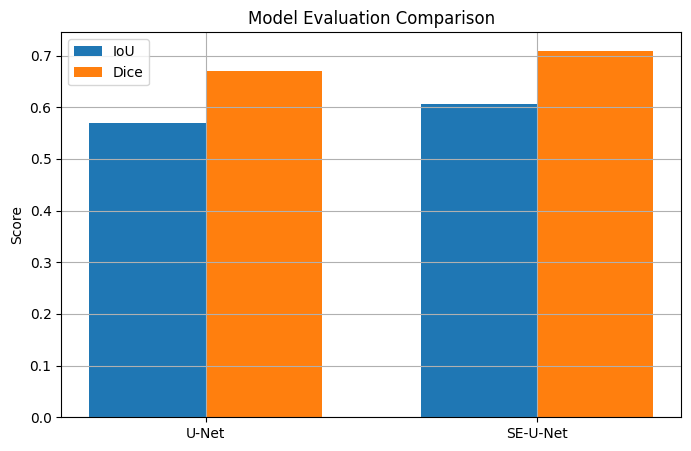

In [ ]:
models = ['U-Net', 'SE-U-Net']
ious = [iou_u, iou_se]
dices = [dice_u, dice_se]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, ious, width, label='IoU')
plt.bar(x + width/2, dices, width, label='Dice')
plt.xticks(x, models)
plt.ylabel("Score")
plt.title("Model Evaluation Comparison")
plt.legend()
plt.grid(True)
plt.show()

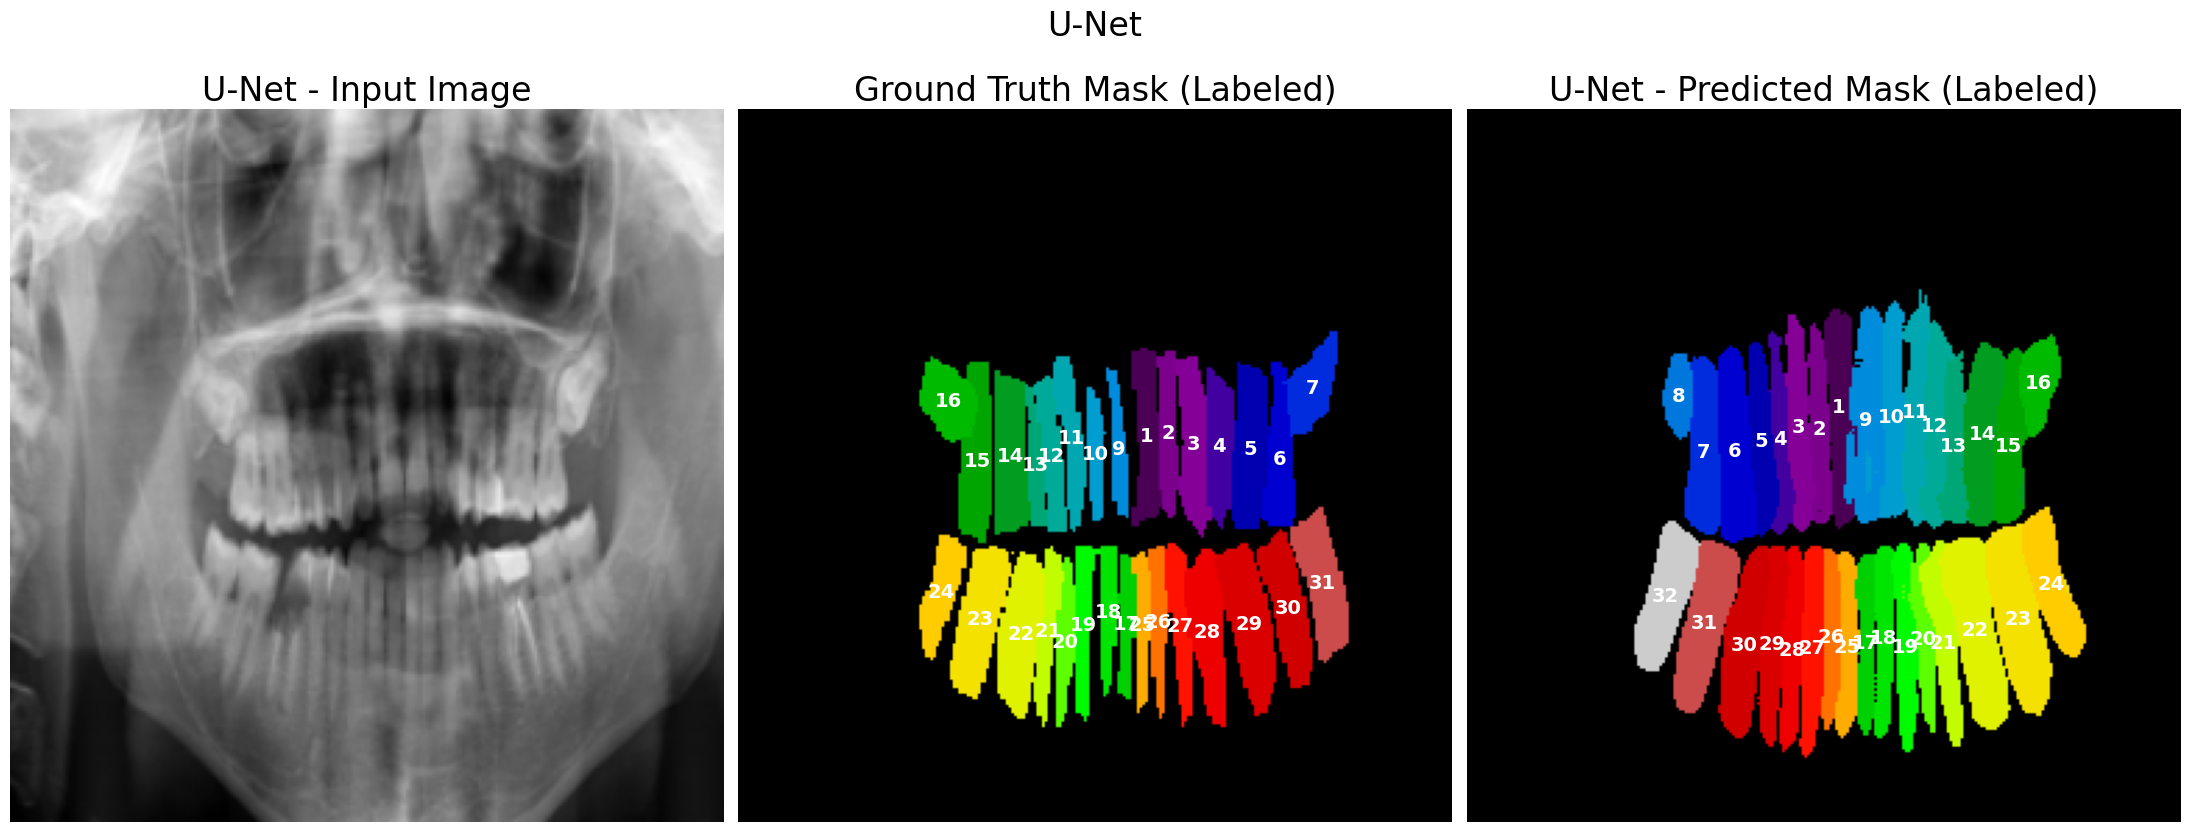

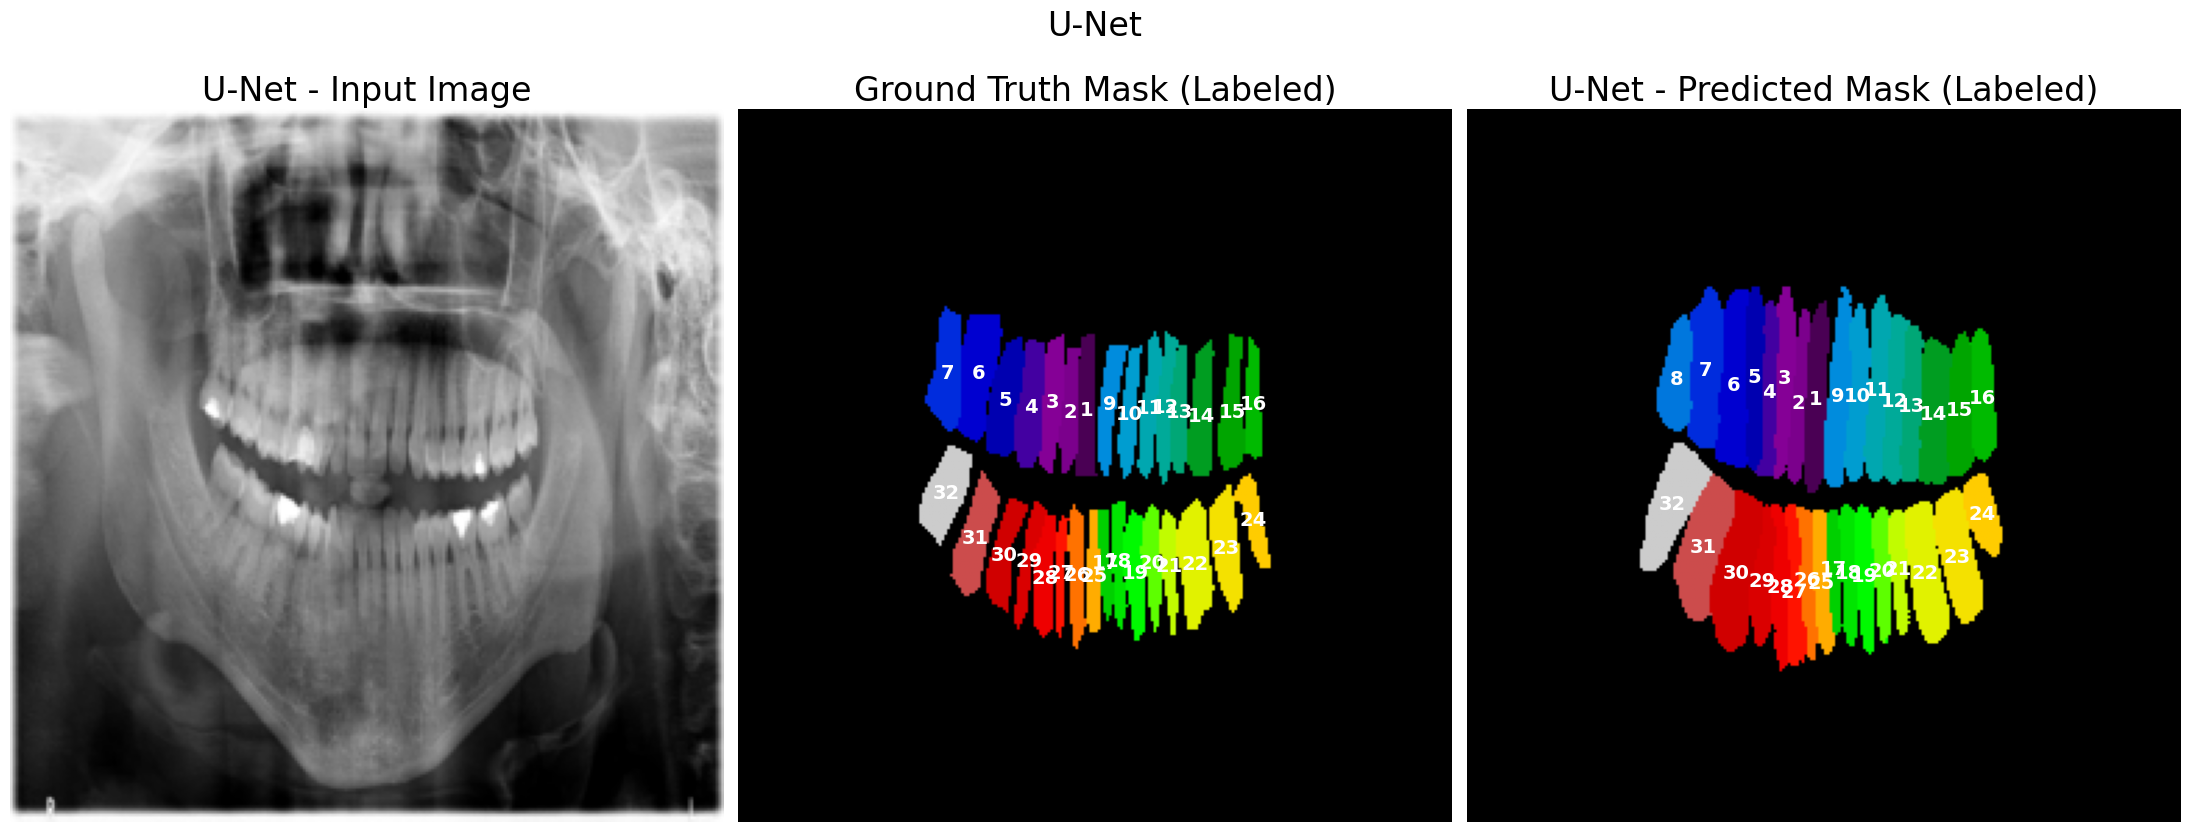

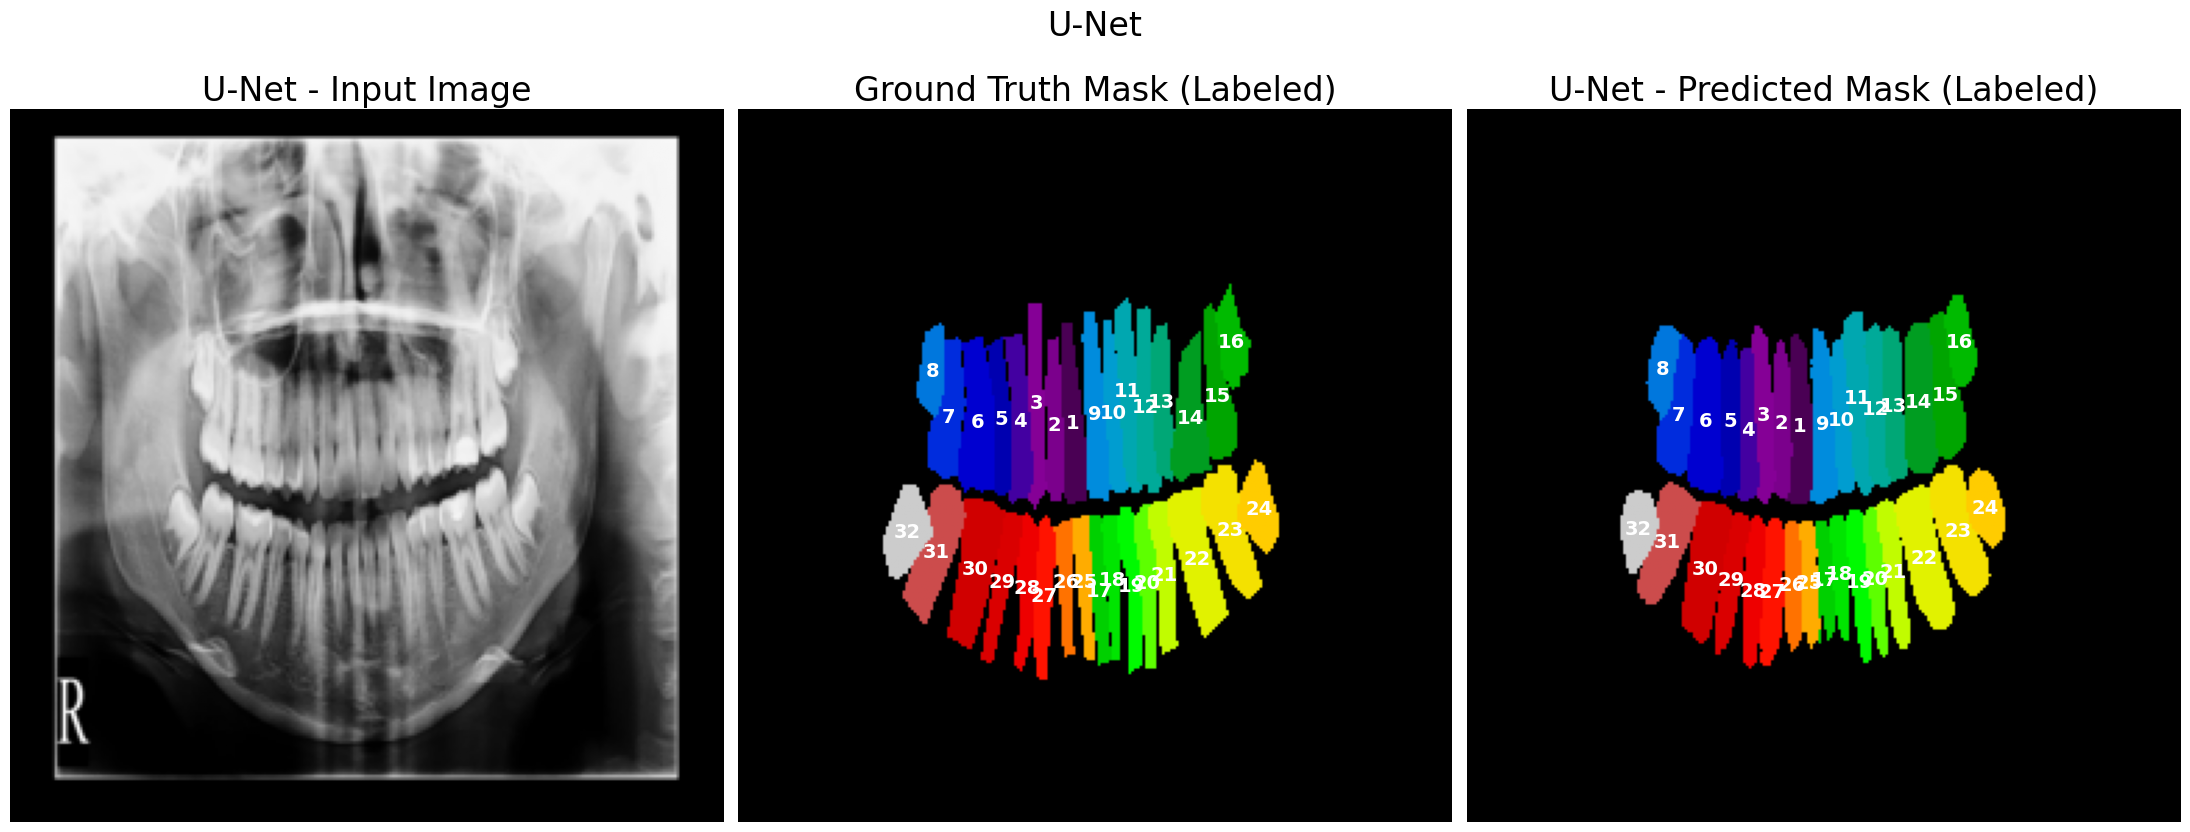

In [ ]:
visualize_model_predictions(unet_model, val_dataset, model_name="U-Net")

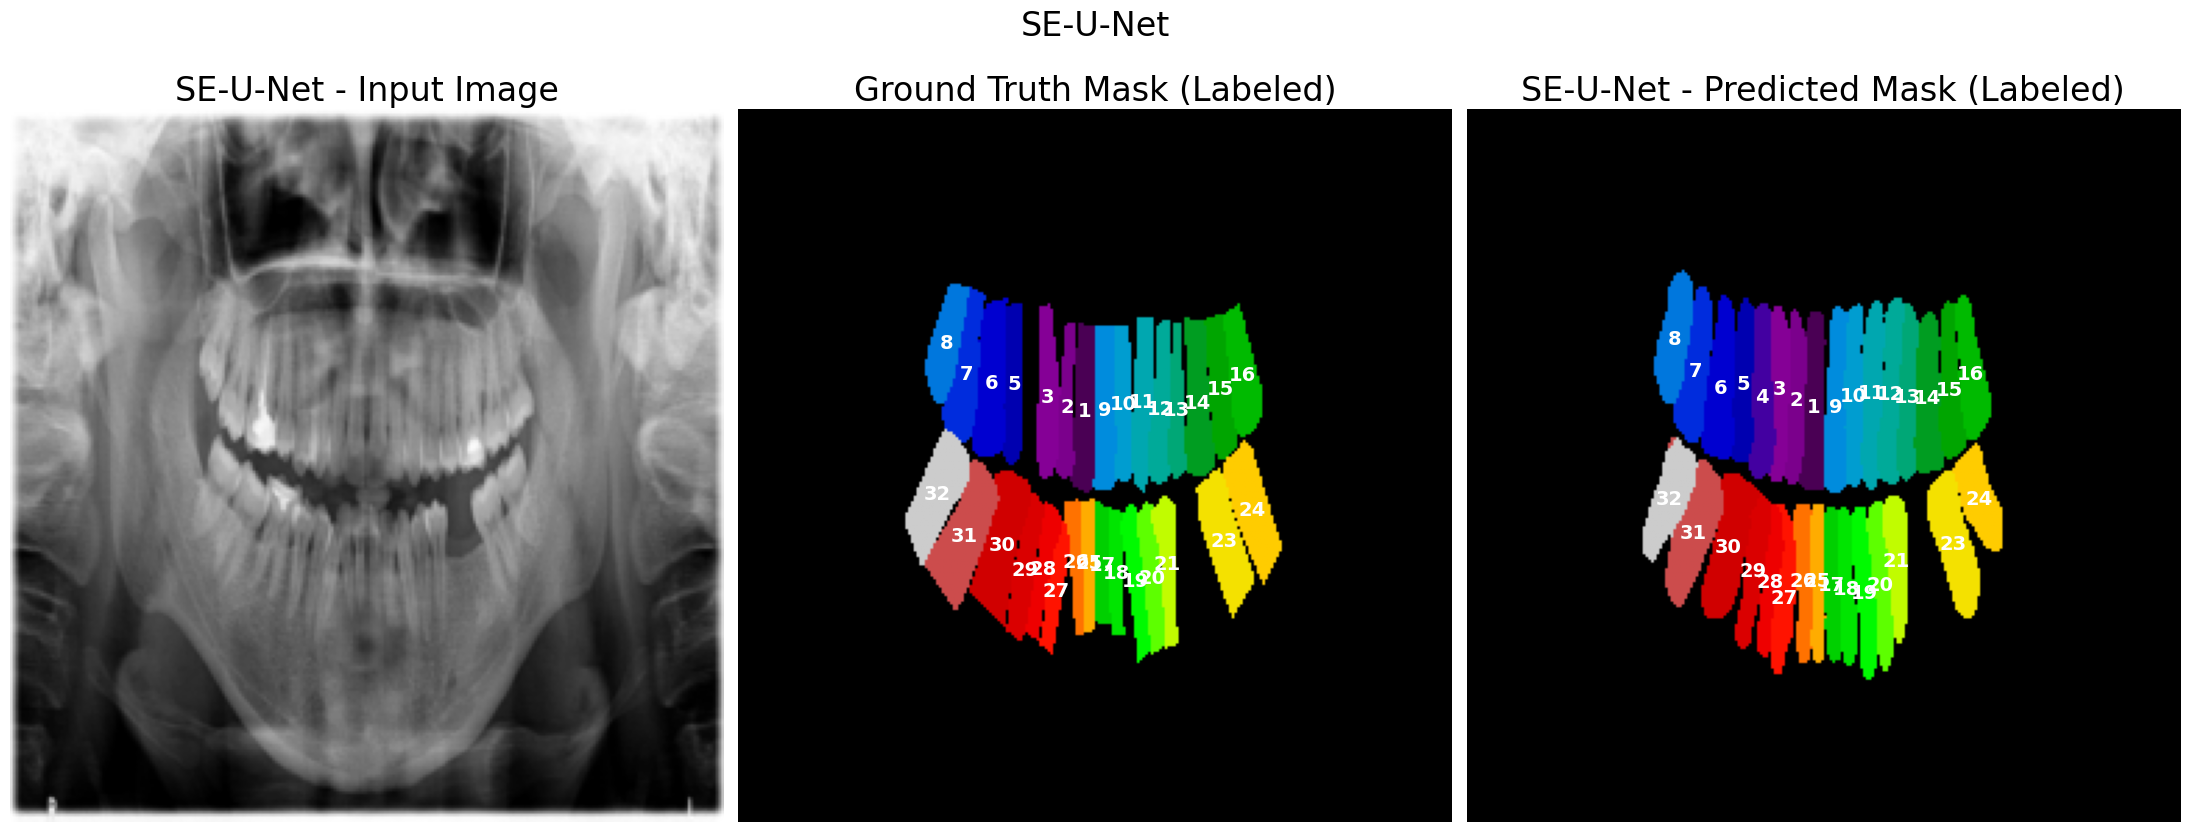

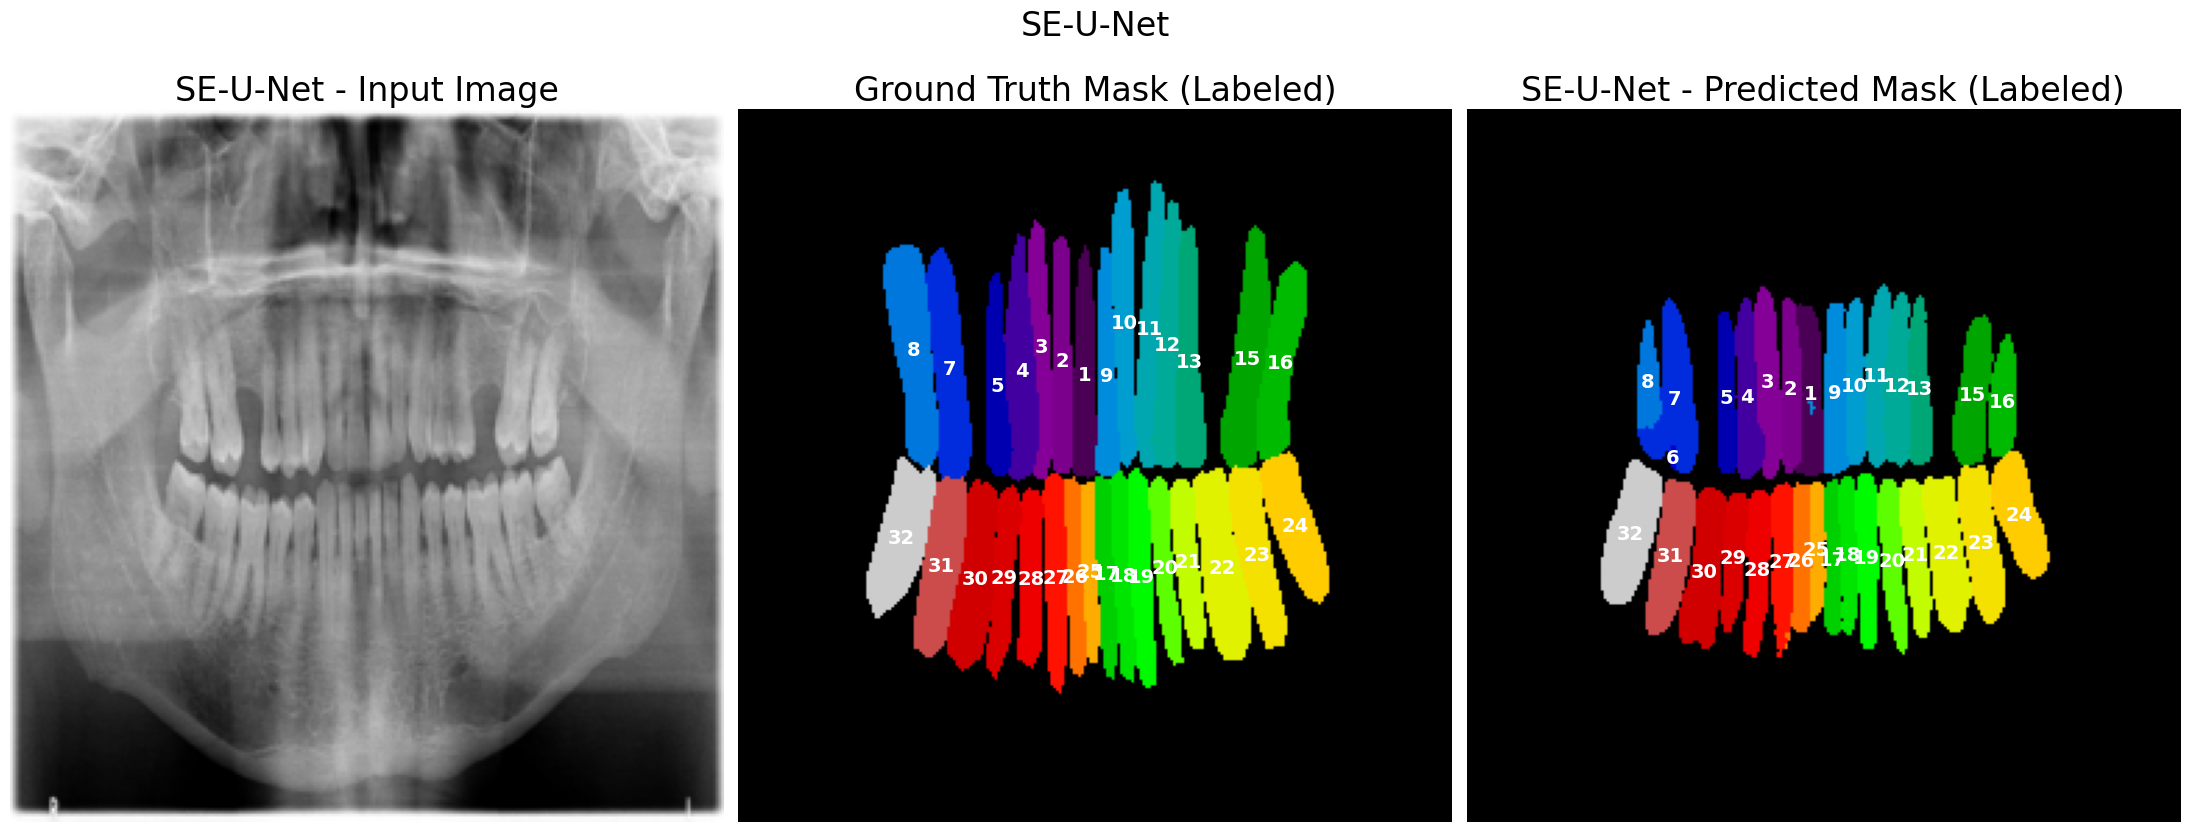

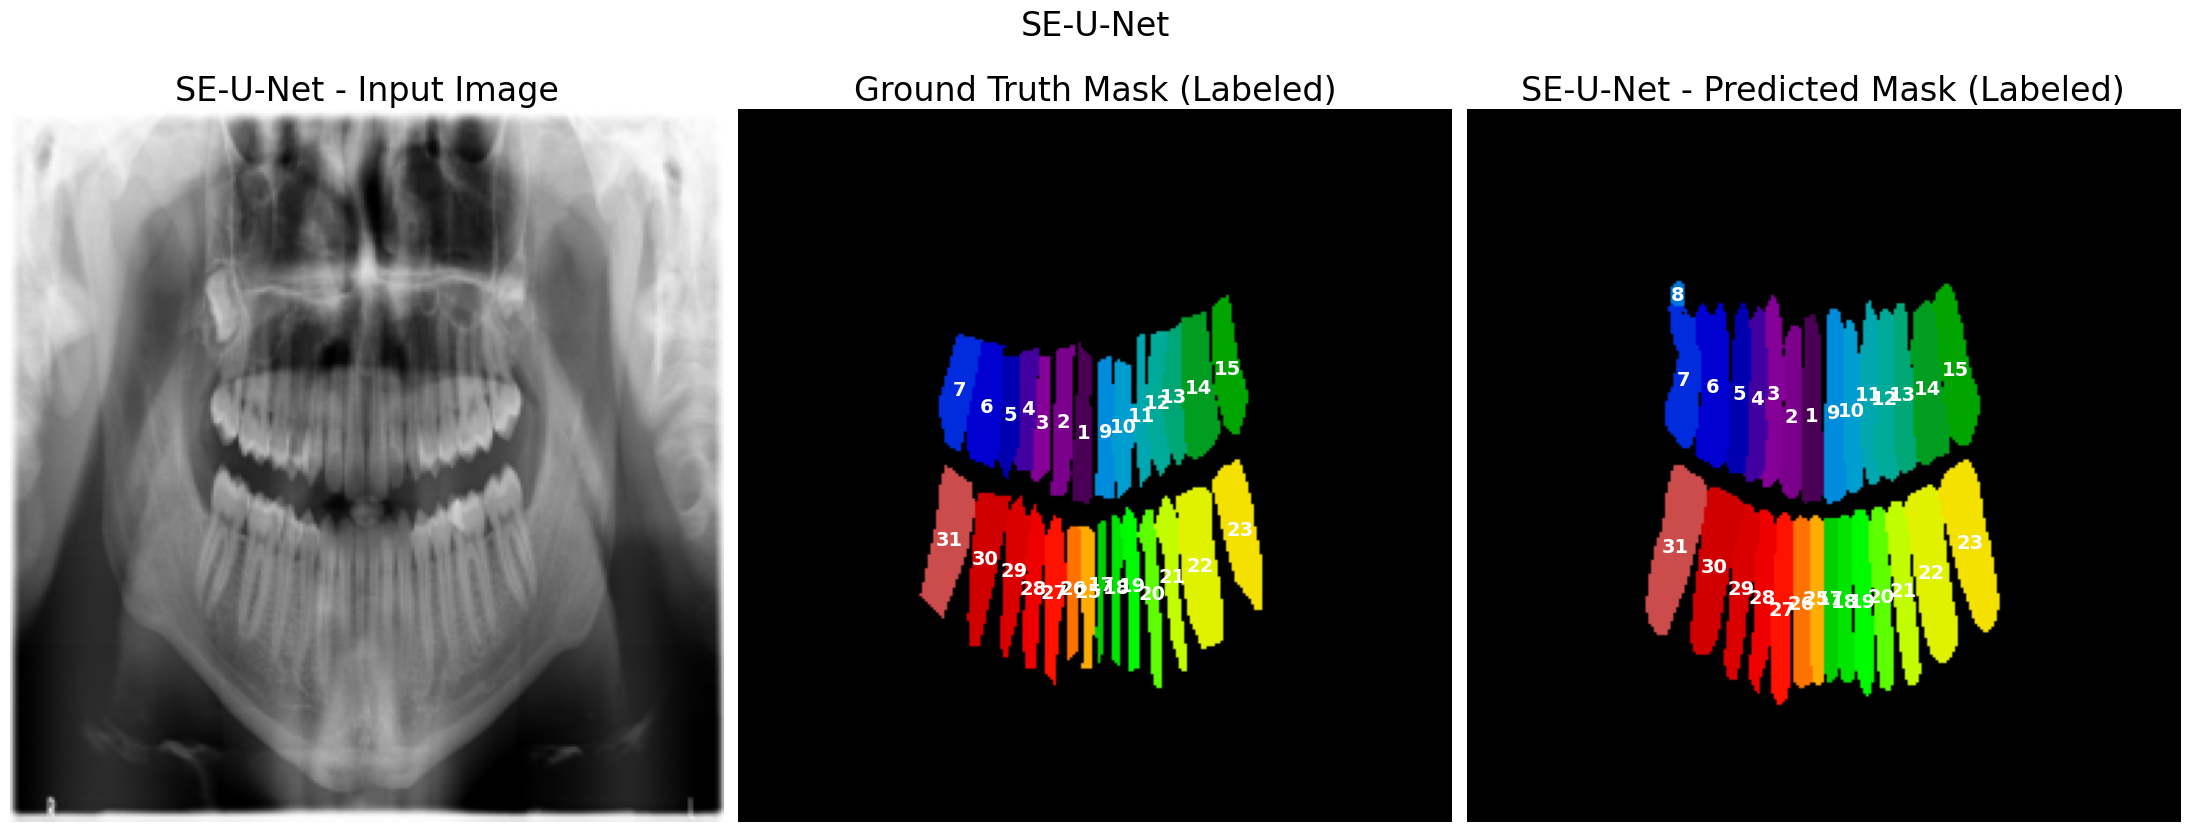

In [ ]:
visualize_model_predictions(seunet_model, val_dataset, model_name="SE-U-Net")

# **This is the new code**

In [1]:
import os
import json
import shutil
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm

def coco_to_unet_format(coco_path, output_dir, original_image_dir):
    with open(coco_path, "r") as f:
        coco = json.load(f)

    os.makedirs(f"{output_dir}/masks", exist_ok=True)
    os.makedirs(f"{output_dir}/xrays", exist_ok=True)

    image_id_to_filename = {img["id"]: img["file_name"] for img in coco["images"]}

    # Prepare annotations by image_id
    anns_per_image = {}
    for ann in coco["annotations"]:
        anns_per_image.setdefault(ann["image_id"], []).append(ann)

    image_names = []
    for image in tqdm(coco["images"], desc="Processing images"):
        file_name = image["file_name"]
        image_id = image["id"]
        width, height = image["width"], image["height"]

        # Copy grayscale image
        src = os.path.join(original_image_dir, file_name)
        dst = os.path.join(f"{output_dir}/xrays", file_name)
        shutil.copy(src, dst)

        # Draw mask
        mask = Image.new("L", (width, height))
        draw = ImageDraw.Draw(mask)

        for ann in anns_per_image.get(image_id, []):
            label = ann["category_id"] + 1  # shift to 1~32 for class id
            segmentation = ann["segmentation"]
            if isinstance(segmentation[0], list):  # COCO polygon format
                points = [tuple(segmentation[0][i:i+2]) for i in range(0, len(segmentation[0]), 2)]
            else:
                points = [tuple(segmentation[i:i+2]) for i in range(0, len(segmentation), 2)]
            draw.polygon(points, fill=label)

        mask.save(os.path.join(f"{output_dir}/masks", file_name))
        image_names.append(file_name)

    # Save image names
    with open(f"{output_dir}/image_names.json", "w") as f:
        json.dump(image_names, f, indent=2)

# Usage
coco_to_unet_format(
    coco_path="/content/drive/MyDrive/enumeration32_Test/Unet__SE-Unet/_annotations.coco.json",
    output_dir="/content/drive/MyDrive/enumeration32_Test/Unet__SE-Unet",  # match train_unet.py usage
    original_image_dir="/content/drive/MyDrive/enumeration32_Test/Unet__SE-Unet/valid"
)


Processing images: 100%|██████████| 123/123 [01:50<00:00,  1.11it/s]


In [1]:
import sys
sys.path.append("/content/drive/MyDrive/")

In [2]:
!pip install SimpleITK fvcore ultralytics addict yapf==0.31.0 tqdm pycocotools

DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/MultiScaleDeformableAttention-1.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.7/185.7 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [3]:
import glob
import numpy as np
import os
import cv2
from tqdm import tqdm
import sys

import json
import torch
from PIL import Image
import SimpleITK as sitk
from torchvision import transforms as T
from torchvision.transforms import functional as F
from torchvision.ops import box_iou
from detectron2.config import get_cfg
from detectron2.engine.defaults import DefaultPredictor
from models.diffusiondet import DiffusionDetDatasetMapper, add_diffusiondet_config, DiffusionDetWithTTA
from models.diffusiondet.util.model_ema import add_model_ema_configs
from ultralytics import YOLO
from models.unet.utils import load_unet, load_seunet
from util.slconfig import SLConfig

from util.weighted_boxes_fusion import weighted_boxes_fusion
import models.dino.datasets.transforms as DT
import argparse
import torch.serialization
torch.serialization.add_safe_globals([argparse.Namespace])
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

quadrant_remap = {
    0: 1,
    1: 0,
    2: 2,
    3: 3,
}

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
class SegmentationPredictor:
    def __init__(self, model, mean=0.458, std=0.173, cuda=True) -> None:
        self.model = model
        self.model.eval()
        self.cuda = cuda
        self.mean = mean  # default mean and std here are caculated from dentex dataset
        self.std = std

    def predict(self, image: np.ndarray) -> torch.Tensor:
        origin_shape = image.shape
        image = Image.fromarray(image).resize((256, 256))
        image = F.to_tensor(image)
        image = F.normalize(image, [self.mean], [self.std])
        if self.cuda:
            image = image.cuda()
        image = image.unsqueeze(0)

        predictions = self.model(image)
        predictions = predictions.squeeze(0)
        predictions = torch.argmax(predictions, dim=0, keepdim=True)
        predictions = F.resize(predictions, origin_shape, F.InterpolationMode.NEAREST)
        return predictions.squeeze(0)
#---------------------------------------------------------------------------------------
def label_mask_to_bbox(mask: np.ndarray):
    """
    convert segmentation mask to bbox, only keep the largest connected component for each label
    mask: (H, W)
    return: bbox_dict, key is label, value is bbox (x, y, w, h)
    """
    bbox_dict = {}
    for label in np.unique(mask):
        if label == 0:
            continue
        label_mask = mask == label
        label_mask = label_mask.astype(np.uint8)
        contours, hierarchy = cv2.findContours(label_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
        if len(contours) == 0:
            continue
        bbox = cv2.boundingRect(contours[0])
        bbox_dict[label] = bbox
    return bbox_dict

In [5]:
with torch.no_grad():
    confidence_threshold = 0.01
    cuda = True
    iou_match_threshold = 0.4
    container = True
    enumeration32_segmentation_models = [
        load_unet("/content/drive/MyDrive/output_unet_enum32_07-25_13-34/epoch_166_loss_0.5442415252327919.pth", 33, cuda=cuda),
        load_seunet("/content/drive/MyDrive/output_seunet_enum32_07-25_16-46/epoch_148_loss_0.5509927049279213.pth", 33, cuda=cuda),
        load_seunet("/content/drive/MyDrive/output_seunet_enum32_07-25_16-46/epoch_201_loss_0.5455089658498764.pth", 33, cuda=cuda),
    ]
    enumeration32_segmentation_predictors = [
        SegmentationPredictor(model, cuda=cuda) for model in enumeration32_segmentation_models
    ]

In [6]:
import os
import json
import cv2
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image

# --- Load COCO Metadata ---
with open("/content/drive/MyDrive/enumeration32_Test/Dino_ResNet50/enum32_my_test.json", "r") as f:
    coco = json.load(f)

list_ids_final = []
for image_info in coco["images"]:
    list_ids_final.append({
        "file_name": image_info["file_name"],
        "height": image_info["height"],
        "width": image_info["width"],
        "id": image_info["id"]
    })

# --- Load PNG images into a dictionary ---
input_image_dir = "/content/drive/MyDrive/enumeration32_Test/Unet__SE-Unet/valid"
image_array = {}
for item in tqdm(list_ids_final, desc="Loading images"):
    img_path = os.path.join(input_image_dir, item["file_name"])
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {img_path}")
    image_array[item["id"]] = img

# --- Output directory for predicted masks ---
save_mask_dir = "/content/drive/MyDrive/enumeration32_Test/Unet__SE-Unet/PredictedMasks"
os.makedirs(save_mask_dir, exist_ok=True)

print("Task type: test")
with torch.no_grad():
    for entry in tqdm(list_ids_final, desc="Inference"):
        image_id = entry["id"]
        image_name = entry["file_name"]
        image_height = entry["height"]
        image_width = entry["width"]

        print(f"Processing {image_name}, id {image_id}...")

        image_rgb_arr = image_array[image_id][:image_height, :image_width, :]
        image_bgr_arr = image_rgb_arr[:, :, ::-1]
        image_gray_arr = cv2.cvtColor(image_bgr_arr, cv2.COLOR_BGR2GRAY)

        # Full-size prediction mask (H x W)
        combined_pred_mask = np.zeros((image_height, image_width), dtype=np.uint8)

        # --- Run all segmentation models ---
        for predictor in enumeration32_segmentation_predictors:
            pred_mask = predictor.predict(image_gray_arr).cpu().numpy()
            # Combine predictions: override only where pred > 0
            combined_pred_mask[pred_mask > 0] = pred_mask[pred_mask > 0]

        # --- Save predicted mask as PNG ---
        Image.fromarray(combined_pred_mask).save(os.path.join(save_mask_dir, image_name))


Loading images: 100%|██████████| 123/123 [02:00<00:00,  1.02it/s]


Task type: test


Inference:   0%|          | 0/123 [00:00<?, ?it/s]

Processing train_106_png.rf.ac175929bf6c73f1cee3506a4a121d80.jpg, id 1...


Inference:   2%|▏         | 3/123 [00:00<00:32,  3.69it/s]

Processing train_162_png.rf.d810c16a2c9177b9a246af90d495d121.jpg, id 2...
Processing train_167_png.rf.06c1d672bc2b66679d8fc05784c185ba.jpg, id 3...
Processing train_419_png.rf.a7eb8be40f86b13288a33eed113d003f.jpg, id 4...


Inference:   4%|▍         | 5/123 [00:01<00:21,  5.61it/s]

Processing train_291_png.rf.b625019ddaea85efe8b6c7128a346e41.jpg, id 5...
Processing train_275_png.rf.30c5ca0272ec6804ce9780d4c523225e.jpg, id 6...
Processing train_553_png.rf.67fbe5f999475111fa07f3492278daee.jpg, id 7...


Inference:   7%|▋         | 9/123 [00:01<00:13,  8.27it/s]

Processing train_140_png.rf.32d6588a18d82189fffdebb45fd6611e.jpg, id 8...
Processing train_614_png.rf.29c357d4867009c8aa20716b7c31aa70.jpg, id 9...
Processing train_514_png.rf.986554788e1fc31d33a2be7d4855dda8.jpg, id 10...


Inference:   9%|▉         | 11/123 [00:01<00:12,  9.08it/s]

Processing train_304_png.rf.5d53f4fae0e8aec63480654151966a38.jpg, id 11...
Processing train_102_png.rf.4995be109236034242752d3953ba931f.jpg, id 12...
Processing train_568_png.rf.e0b00b9f71455c9253310b4c7d9bfadb.jpg, id 13...


Inference:  12%|█▏        | 15/123 [00:02<00:10, 10.18it/s]

Processing train_46_png.rf.149c28bdd4e5eedc74902c1165347547.jpg, id 14...
Processing train_267_png.rf.b89d1e49f885755c82fa7552a3c408ee.jpg, id 15...
Processing train_64_png.rf.cc544fb3568152eb2558c94f6fef74f8.jpg, id 16...


Inference:  14%|█▍        | 17/123 [00:02<00:10, 10.45it/s]

Processing train_15_png.rf.b5d3e5405b88f6e5342351aa54f1dcc4.jpg, id 17...
Processing train_547_png.rf.4b1791de9cb73626b980f0f561cc648e.jpg, id 18...
Processing train_287_png.rf.fc6fb140a1b764895f8cfe9c1e7e03a9.jpg, id 19...


Inference:  17%|█▋        | 21/123 [00:02<00:09, 10.88it/s]

Processing train_414_png.rf.0a374a8ece4408a9f2ca764136bd8060.jpg, id 20...
Processing train_618_png.rf.86f8f7dddf6d8148bde4e71d66850f6d.jpg, id 21...
Processing train_222_png.rf.a9d787c151a97e4e2a577b2e82ab1b38.jpg, id 22...


Inference:  19%|█▊        | 23/123 [00:02<00:09, 10.89it/s]

Processing train_30_png.rf.4d8b6c6553e10d784bd53d0710d6292f.jpg, id 23...
Processing train_321_png.rf.d2400a53e34c35bba35afcadf38154d8.jpg, id 24...
Processing train_244_png.rf.2df06bb8ed83dd4f8d5186abc48121e0.jpg, id 25...


Inference:  22%|██▏       | 27/123 [00:03<00:08, 10.85it/s]

Processing train_250_png.rf.bda94a5de99e7e3f66d215a79c80b6ca.jpg, id 26...
Processing train_447_png.rf.8b3b91c4fd4982b2e716abbdc8b02627.jpg, id 27...
Processing train_406_png.rf.d978133acb73e8bbd56aee4bab5bba47.jpg, id 28...


Inference:  24%|██▎       | 29/123 [00:03<00:08, 10.86it/s]

Processing train_178_png.rf.6f876cc1a86eed7b6fcf78a75c7c8028.jpg, id 29...
Processing train_556_png.rf.c8f87c4491a39bc0a801c7cf35c50e4c.jpg, id 30...
Processing train_239_png.rf.cfbaaf8625c9bb23a4c87ba8810df73b.jpg, id 31...


Inference:  27%|██▋       | 33/123 [00:03<00:08, 10.99it/s]

Processing train_524_png.rf.e29271659189c0fce9d513139688e1d5.jpg, id 32...
Processing train_397_png.rf.044799265487918013f831e44e4d767b.jpg, id 33...
Processing train_211_png.rf.20e23693f8712d56dd1c7ffc31742bd7.jpg, id 34...


Inference:  28%|██▊       | 35/123 [00:03<00:07, 11.01it/s]

Processing train_145_png.rf.eb726efb2e766009436bd627249a698c.jpg, id 35...
Processing train_439_png.rf.46468c8abca83c71d3d51bb236fac523.jpg, id 36...
Processing train_266_png.rf.c1c6c3195bde0a0e5ad42d80583607a6.jpg, id 37...


Inference:  32%|███▏      | 39/123 [00:04<00:07, 10.84it/s]

Processing train_130_png.rf.e8454fa68d57edf8d79b50be12b4409f.jpg, id 38...
Processing train_316_png.rf.876d3f6717e8853304536bcb86db16f6.jpg, id 39...
Processing train_186_png.rf.f290d513829ade700bb76c84aa4541a6.jpg, id 40...


Inference:  33%|███▎      | 41/123 [00:04<00:07, 10.86it/s]

Processing train_504_png.rf.7f999246f47eb755066fca997591f183.jpg, id 41...
Processing train_409_png.rf.05684c5d544cbc49440286cc0996c1c9.jpg, id 42...
Processing train_388_png.rf.20c401da9e964fd536fa5906c4bf8e77.jpg, id 43...


Inference:  37%|███▋      | 45/123 [00:04<00:07, 10.92it/s]

Processing train_548_png.rf.47551d3761a9f882ae8203c3dba12f56.jpg, id 44...
Processing train_100_png.rf.4258909bc7d0f5962b7c19aec390a201.jpg, id 45...
Processing train_154_png.rf.cce11039fba6b7adc0a2e8f861112f67.jpg, id 46...


Inference:  38%|███▊      | 47/123 [00:04<00:06, 10.92it/s]

Processing train_92_png.rf.c94b1bdc93b8b3c7b7e699d6be75c3d9.jpg, id 47...
Processing train_437_png.rf.15d78cb15c21ac88b882a1fc7f232559.jpg, id 48...
Processing train_29_png.rf.4a51d7364e5aaa1bd5338d4c21fd3a7f.jpg, id 49...


Inference:  41%|████▏     | 51/123 [00:05<00:06, 10.99it/s]

Processing train_99_png.rf.0a467004c8999a80eda0f87574837cef.jpg, id 50...
Processing train_219_png.rf.3c93c9dda80d7355be2d4fc0ecac3997.jpg, id 51...
Processing train_487_png.rf.502e8562d8f50d86bdba70cc8d16e0ed.jpg, id 52...


Inference:  43%|████▎     | 53/123 [00:05<00:06, 10.79it/s]

Processing train_18_png.rf.2d960ecbc2387fbf7fc9c900bfa3940b.jpg, id 53...
Processing train_157_png.rf.3372f71a60bb927369a7d5081a1501ad.jpg, id 54...
Processing train_625_png.rf.8103685380453a5d2ab9ec9746a81a87.jpg, id 55...


Inference:  46%|████▋     | 57/123 [00:05<00:06, 10.85it/s]

Processing train_396_png.rf.6d4ef0f510d72c3b68b83d3e31d6eb4f.jpg, id 56...
Processing train_7_png.rf.372957333bfe68726695932157e89492.jpg, id 57...
Processing train_32_png.rf.f8156cfba883d49c278f1daa97b087e6.jpg, id 58...


Inference:  48%|████▊     | 59/123 [00:06<00:05, 10.92it/s]

Processing train_598_png.rf.03f88499bab1bb74fe73756375cf19fd.jpg, id 59...
Processing train_204_png.rf.41bd8dc01073fc5004281abe96a10535.jpg, id 60...
Processing train_581_png.rf.2ed93b07d8a402a48ee583820ee5b7ba.jpg, id 61...


Inference:  51%|█████     | 63/123 [00:06<00:05, 10.99it/s]

Processing train_557_png.rf.b454737a1ec0f30e360cc99d0ea8fddf.jpg, id 62...
Processing train_534_png.rf.e2085ee6aa01e9fcb8d269bf0de188cb.jpg, id 63...
Processing train_117_png.rf.1cea0f93616efd623a7ee52f259a3219.jpg, id 64...


Inference:  53%|█████▎    | 65/123 [00:06<00:05, 11.05it/s]

Processing train_390_png.rf.58369b03fded277deff27787f70c3039.jpg, id 65...
Processing train_596_png.rf.e5baa14512a3f5452a7889ac638076cc.jpg, id 66...
Processing train_474_png.rf.82b8ebe307d78af9422808a879509fdc.jpg, id 67...


Inference:  56%|█████▌    | 69/123 [00:06<00:04, 10.96it/s]

Processing train_401_png.rf.157dc6c895ec4849b13709f7eaf66aea.jpg, id 68...
Processing train_459_png.rf.0d2529bbecc443801cc8e8fe3b8b9fe0.jpg, id 69...
Processing train_500_png.rf.4eb3439299442cf4c2937c65edd7c377.jpg, id 70...


Inference:  58%|█████▊    | 71/123 [00:07<00:04, 11.01it/s]

Processing train_293_png.rf.778e5333afa4ca37b168a06dc4f98e82.jpg, id 71...
Processing train_463_png.rf.599ca50311c00d06f2955261354b2a68.jpg, id 72...
Processing train_86_png.rf.dfea4d83e34b549dd0b3136e071853bf.jpg, id 73...


Inference:  61%|██████    | 75/123 [00:07<00:04, 11.07it/s]

Processing train_503_png.rf.cf9f259107b0ac5beb9e393a8866e8ce.jpg, id 74...
Processing train_76_png.rf.e137b3ae6bed181cfa727d25be401a5c.jpg, id 75...
Processing train_405_png.rf.d4d12b53a15108a0d88877deeff87de2.jpg, id 76...


Inference:  63%|██████▎   | 77/123 [00:07<00:04, 11.11it/s]

Processing train_235_png.rf.8454f787b1a2380d2bc96abad3fb30d5.jpg, id 77...
Processing train_38_png.rf.8904da16f4b0aec660aadb578e1c7383.jpg, id 78...
Processing train_187_png.rf.84a08f2f4649fc5f291f0c3cc8161bda.jpg, id 79...


Inference:  66%|██████▌   | 81/123 [00:08<00:03, 11.20it/s]

Processing train_33_png.rf.6581f790ccef5582f6141beded667c5e.jpg, id 80...
Processing train_443_png.rf.d077d6fc921904c502eecd7739b54398.jpg, id 81...
Processing train_319_png.rf.17d5fb475787f7f9e545ae61a90ce4f6.jpg, id 82...


Inference:  67%|██████▋   | 83/123 [00:08<00:03, 10.99it/s]

Processing train_582_png.rf.47729129fdf9035dce7b5766ab237ba0.jpg, id 83...
Processing train_82_png.rf.4bf4dc51565d0bdd1aee7b944f907bb8.jpg, id 84...
Processing train_176_png.rf.674b4324c4d37de4d8958dbb78b236b7.jpg, id 85...


Inference:  71%|███████   | 87/123 [00:08<00:03, 11.10it/s]

Processing train_617_png.rf.5ea1c4df84476ecb03f1a43d80f12c99.jpg, id 86...
Processing train_25_png.rf.6aa2f6ef9a929144e83966353c45cbb3.jpg, id 87...
Processing train_478_png.rf.02a67a1b8a042a2be4c818d8fe2656c3.jpg, id 88...


Inference:  72%|███████▏  | 89/123 [00:08<00:03, 11.15it/s]

Processing train_619_png.rf.f2ad7e61d616f90d9c330d6b92894939.jpg, id 89...
Processing train_88_png.rf.b91f1da79a70fae9acf351b4bf136689.jpg, id 90...
Processing train_3_png.rf.a7b9f39880336f6b5fbd833492934962.jpg, id 91...


Inference:  76%|███████▌  | 93/123 [00:09<00:02, 11.18it/s]

Processing train_263_png.rf.ce40033b9fdf68a526c629072d634b26.jpg, id 92...
Processing train_460_png.rf.37d5dc70c60ae05ea2b21a2701fc0026.jpg, id 93...
Processing train_616_png.rf.31a2f4bc30b711016ccd9710a7655fb4.jpg, id 94...


Inference:  77%|███████▋  | 95/123 [00:09<00:02, 11.15it/s]

Processing train_560_png.rf.9d07483e781de276d4d810ccfce6fc5b.jpg, id 95...
Processing train_546_png.rf.501c3dcee2dceb76adae8f439d4468b0.jpg, id 96...
Processing train_47_png.rf.5967eddaa2bb0fe303eaed29200c25f5.jpg, id 97...


Inference:  80%|████████  | 99/123 [00:09<00:02, 10.89it/s]

Processing train_429_png.rf.6b859df1351f13d13f4b649029edc96f.jpg, id 98...
Processing train_218_png.rf.f81f433c5d97db9fb0f2d1b087ea5810.jpg, id 99...
Processing train_253_png.rf.000d3449840192590cc96edf0a3dbbf3.jpg, id 100...


Inference:  82%|████████▏ | 101/123 [00:09<00:02, 10.95it/s]

Processing train_533_png.rf.3daf0bc85e8c5c3d416693ce7bdaeaf3.jpg, id 101...
Processing train_494_png.rf.de76e87cceba7ad527f4383d32b8590d.jpg, id 102...
Processing train_454_png.rf.b1bfde5fd82186a283b22cd2ad319643.jpg, id 103...


Inference:  85%|████████▌ | 105/123 [00:10<00:01, 10.99it/s]

Processing train_103_png.rf.a1a9500d895ec5a05e0df7a7e7067d7f.jpg, id 104...
Processing train_58_png.rf.03d7bb912b13a9958d0ee247ea404f43.jpg, id 105...
Processing train_632_png.rf.98c92e5909ce575cc2fdf1b4ddb90eb6.jpg, id 106...


Inference:  87%|████████▋ | 107/123 [00:10<00:01, 11.01it/s]

Processing train_42_png.rf.b0ccbff3eece4d9b961a0324fcce9ac4.jpg, id 107...
Processing train_350_png.rf.fd10f6a98feaa720fc2733b3b4f71ee7.jpg, id 108...
Processing train_599_png.rf.e84e1dcbcc9a8606a3a4ade275ff2e2b.jpg, id 109...


Inference:  90%|█████████ | 111/123 [00:10<00:01, 10.70it/s]

Processing train_384_png.rf.435ccdc55fe24cb34e95ac7cd14753eb.jpg, id 110...
Processing train_601_png.rf.e07c550ca10c16ee422837bffcf133d2.jpg, id 111...
Processing train_575_png.rf.2814d50f316bbcaea1adae3530ffd84d.jpg, id 112...


Inference:  92%|█████████▏| 113/123 [00:10<00:00, 10.84it/s]

Processing train_442_png.rf.4d3bb2206226db170eaf6fdc6d2dae38.jpg, id 113...
Processing train_124_png.rf.1afb7a8f8382fdfcc30bfbaf9eaf1d18.jpg, id 114...
Processing train_325_png.rf.03778220b1b250454698a08ccc694269.jpg, id 115...


Inference:  95%|█████████▌| 117/123 [00:11<00:00, 10.79it/s]

Processing train_174_png.rf.f98a31691abe95b260c2a7aa2fa5fef0.jpg, id 116...
Processing train_572_png.rf.6084632aa44ffae577cb5c922b2305e0.jpg, id 117...
Processing train_464_png.rf.41ca74289dea18b4a98fb513e5c992ef.jpg, id 118...


Inference:  97%|█████████▋| 119/123 [00:11<00:00, 10.87it/s]

Processing train_185_png.rf.6097a2a7d19cc612e9caa15fe6aa822b.jpg, id 119...
Processing train_233_png.rf.b7a779c91f5b5540a3393e4f7434435e.jpg, id 120...
Processing train_50_png.rf.8a364da4bad604048f0aaf2a1480705d.jpg, id 121...


Inference: 100%|██████████| 123/123 [00:11<00:00, 10.36it/s]

Processing train_173_png.rf.57e6e337633fba52a8a2b0b2b22cbf9a.jpg, id 122...
Processing train_208_png.rf.b6a2a1a3802aea3af1e959ff79d420b6.jpg, id 123...


In [13]:
import os
import numpy as np
import torch
from tqdm import tqdm
from PIL import Image
from torch.nn import CrossEntropyLoss
from models.unet.loss.MultiDiceLoss import MultiDiceLoss

pred_dir = "/content/drive/MyDrive/enumeration32_Test/Unet__SE-Unet/PredictedMasks"
gt_dir = "/content/drive/MyDrive/enumeration32_Test/Unet__SE-Unet/masks"

NUM_CLASSES = 33  # 32 teeth + background

dice_loss_func = MultiDiceLoss()
ce_loss_func = CrossEntropyLoss()

dice_total = 0.0
ce_total = 0.0
count = 0

for image_name in tqdm(os.listdir(pred_dir), desc="Evaluating"):
    pred_mask = Image.open(os.path.join(pred_dir, image_name))
    gt_mask = Image.open(os.path.join(gt_dir, image_name))

    pred_tensor = torch.from_numpy(np.array(pred_mask)).long().unsqueeze(0)
    gt_tensor = torch.from_numpy(np.array(gt_mask)).long().unsqueeze(0)

    # Clamp to valid range: 0 <= value < NUM_CLASSES
    pred_tensor = torch.clamp(pred_tensor, min=0, max=NUM_CLASSES - 1)
    gt_tensor = torch.clamp(gt_tensor, min=0, max=NUM_CLASSES - 1)

    # Convert to one-hot
    pred_one_hot = torch.nn.functional.one_hot(pred_tensor, num_classes=NUM_CLASSES).permute(0, 3, 1, 2).float()

    dice = dice_loss_func(pred_one_hot, gt_tensor)
    ce = ce_loss_func(pred_one_hot, gt_tensor)

    dice_total += dice.item()
    ce_total += ce.item()
    count += 1

print(f"✅ Average Dice Loss: {dice_total / count:.4f}")
print(f"✅ Average Cross-Entropy Loss: {ce_total / count:.4f}")


Evaluating: 100%|██████████| 123/123 [02:24<00:00,  1.17s/it]

✅ Average Dice Loss: 0.9976
✅ Average Cross-Entropy Loss: 2.7483


['train_106_png.rf.ac175929bf6c73f1cee3506a4a121d80.jpg',
 'train_162_png.rf.d810c16a2c9177b9a246af90d495d121.jpg',
 'train_167_png.rf.06c1d672bc2b66679d8fc05784c185ba.jpg',
 'train_419_png.rf.a7eb8be40f86b13288a33eed113d003f.jpg',
 'train_291_png.rf.b625019ddaea85efe8b6c7128a346e41.jpg']

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

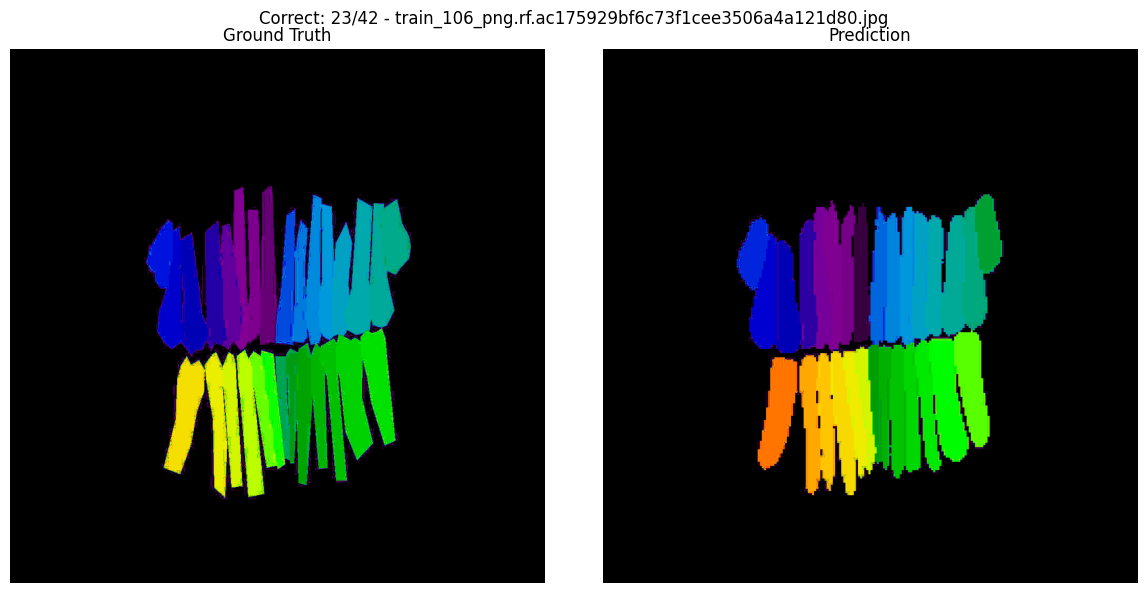

Evaluating:  33%|███▎      | 1/3 [00:03<00:06,  3.18s/it]

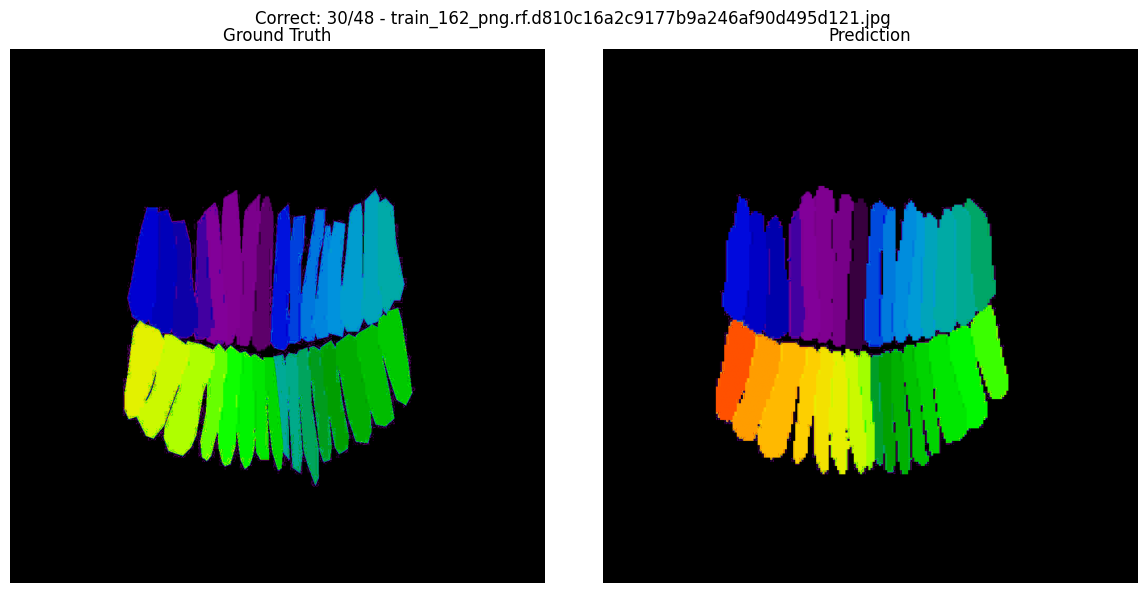

Evaluating:  67%|██████▋   | 2/3 [00:06<00:03,  3.47s/it]

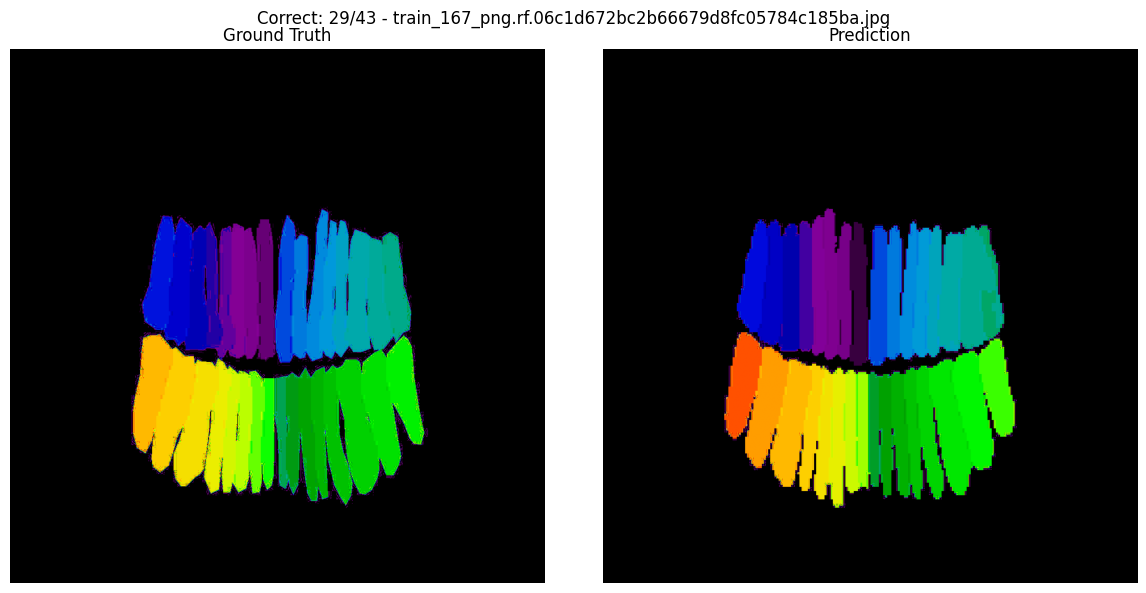

Evaluating: 100%|██████████| 3/3 [00:10<00:00,  3.37s/it]


✅ Total GT teeth: 133
✅ Correctly predicted (IoU>0.5): 82
🎯 Accuracy: 61.65%


In [24]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import cv2

# Config
pred_dir = "/content/drive/MyDrive/enumeration32_Test/Unet__SE-Unet/PredictedMasks"
gt_dir = "/content/drive/MyDrive/enumeration32_Test/Unet__SE-Unet/masks"
image_names = os.listdir(pred_dir)[:3]
iou_threshold = 0.5

# Functions
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0.0
    return intersection / union

def plot_masks(gt_mask, pred_mask, title, image_name):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(gt_mask, cmap="nipy_spectral")
    axs[0].set_title("Ground Truth")
    axs[0].axis("off")

    axs[1].imshow(pred_mask, cmap="nipy_spectral")
    axs[1].set_title("Prediction")
    axs[1].axis("off")

    fig.suptitle(f"{title} - {image_name}")
    plt.tight_layout()
    plt.show()

# Main Evaluation Loop
total_gt_teeth = 0
total_correct = 0
samples_plotted = 0

for image_name in tqdm(image_names, desc="Evaluating"):
    pred_mask = np.array(Image.open(os.path.join(pred_dir, image_name)))
    gt_mask = np.array(Image.open(os.path.join(gt_dir, image_name)))

    correct = 0
    gt_labels = np.unique(gt_mask)
    pred_labels = np.unique(pred_mask)

    gt_labels = gt_labels[gt_labels != 0]  # skip background
    pred_labels = pred_labels[pred_labels != 0]

    total_gt_teeth += len(gt_labels)

    for gt_label in gt_labels:
        gt_binary = (gt_mask == gt_label)
        best_iou = 0.0
        for pred_label in pred_labels:
            pred_binary = (pred_mask == pred_label)
            iou = compute_iou(gt_binary, pred_binary)
            best_iou = max(best_iou, iou)
        if best_iou > iou_threshold:
            correct += 1

    total_correct += correct

    # Plot first 5 examples
    if samples_plotted < 5:
        plot_masks(gt_mask, pred_mask, f"Correct: {correct}/{len(gt_labels)}", image_name)
        samples_plotted += 1

# Summary
print(f"\n✅ Total GT teeth: {total_gt_teeth}")
print(f"✅ Correctly predicted (IoU>{iou_threshold}): {total_correct}")
print(f"🎯 Accuracy: {total_correct / total_gt_teeth:.2%}")
